# ODSC West 2022

## Setup and Preliminaries
### Notebook is in the following repo: www.github.com/numeristical/resources
- #### Clone or download the repo
- #### Navigate to folder "ODSC_West_2022"
- #### Find notebook file "W22_1_GB_Review_Hyper.ipynb"


### Suggestion: make a copy of Notebook, go to Kernel->Restart and Clear All Outputs
(This way you can make changes and still refer to the original)

# About Me
## Brian Lucena
- ### Consultant, Researcher, Educator: www.numeristical.com
- ### Work with many startups, as well as larger (public) companies
- ### Youtube channel on Statistical Machine Learning: https://www.youtube.com/numeristical
- ### Frequent Presenter at ODSC, PyData, MLConf  
- ### StructureBoost package: Gradient Boosting with Categorical Structure: www.github.com/numeristical/structureboost
- ### ML-Insights package: Model Interpretability, Probability Calibration (SplineCalib) www.github.com/numeristical/introspective
- ### Research Papers:
    - "Nonparametric Probabilistic Regression with Coarse Learners" http://arxiv.org/abs/2210.16247 
    - "Loss Functions for Classification Using Structured Entropy" https://arxiv.org/abs/2206.07122
    - "Exploiting Categorical Structure using Tree-based Methods" (AISTATS 2020) http://proceedings.mlr.press/v108/lucena20a/lucena20a.pdf
    - "StructureBoost: Efficient Gradient Boosting for Structured Categorical Variables" https://arxiv.org/abs/2007.04446
    - "Spline-Based Probability Calibration" https://arxiv.org/abs/1809.07751
  

# Advanced Gradient Boosting: Review and Best Practices
- Review of Gradient Boosting, how it works, hyperparameters
- Tuning hyperparameters - different approaches
- Review of different packages (might be skipped to save time)

## Gradient Boosting: History and Terminology

- Generally, when people refer to "Gradient Boosting" what they really mean is "Gradient Boosted Decision Trees"
- "Boosting" in general, originally referred to a process where you fit a model, and then gave more weight to the examples in the training data that it got wrong, refit the model, and then added the new model to the previous one.  
- AdaBoost (Freund and Schapire) was an early example of this, and using trees as the base learner was shown to be quite effective

- Later, it was shown that AdaBoost was equivalent to fitting the base learner to the *gradient* of a particular loss function (exponential). 

- The idea was then generalized to any particular loss function, and referred to as *gradient boosting*.  Additionally, other loss functions were shown to be better in practice than the exponential loss.

- Though the idea can apply to any base learner, decision trees have been most effective.  So, what we are learning about today is *gradient boosting with decision trees as the base learner* or *gradient boosted decision trees* (but usually just called *gradient boosting*)

### Gradient boosting: rough pass
- Consider a regression problem.  Suppose you have a model $M_1$ that already performs reasonably well.  But you would like to improve it if possible.
- You use your model to make predictions on the training data and measure the *residuals*: i.e. the difference between the true answer and the prediction.
- Next, you build a decision tree to try and predict the *residuals* given your predictors.  For example you want to find a tree that can distinguish between the cases where your previous model underpredicted vs overpredicted (and also distinguish between a small under/overprediction and a large under/overprediction)
    
- In theory, if your new tree does a great job at predicting the residuals, you can add the result of the tree to the previous model, and voila, you will have a better model.
- In reality we need to be concerned with overfitting: Suppose the residuals are truly random noise.  With enough predictors, you may find an incidental pattern that works on your training data, but is worthless on new cases.
- Therefore, we do a few things to try to prevent this from happening (i.e. to help *regularize*)
- Most importantly, rather than directly add the new model to the old model, we first multiply it by a small fraction (say .1 or even .01 or .001).  We will do this process many times, so it doesn't (generally) hurt to take small steps.
- It also doesn't matter whether we start with a "pretty good" model.  We can start with a "nothing" model (predict 0 for everything) and still iterate through this process.

## Wait! This makes sense, but I still don't get a few things...
- Where does the loss function come in?
- Where does the gradient come in?
- What if I am doing a classification problem?

## Good questions!
- What I just described was specific to regression.
- In fact, it was specific to regression with a mean squared error loss function
- When using mean squared error, the derivative of the loss function is the residual (distance from the true answer) (times a constant of 2)
- $\frac{\partial}{\partial y} (y -y_t)^2 = 2(y-y_t)$
- So fitting a model to the residuals is *equivalent* to fitting a model to the *gradient of the loss function*
- So the notion of predicting small/large under/overpredictions can be thought of as predicting where my loss is increasing/decreasing by a small/large amount.
- The latter notion will even generalize to cases where the loss function has a weirder form.


## Reiteration of Gradient Boosting
- In general, (for classification, regression with any loss function) we take the current model, use it to make predictions on the training data, and then find the *derivative of the loss function* for each point *at its current predicted value*.
- For most loss functions, the gradient is "steeper" the further you are from the right answer, so the idea of predicting the "degree" of over/underprediction is still the right one.

### Example of a regression loss function

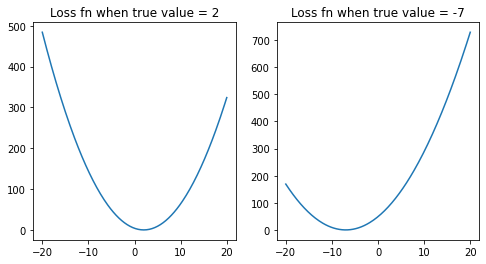

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
tvec1 = np.linspace(-20,20,201)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(tvec1, (tvec1-2)**2)
plt.title('Loss fn when true value = 2')

plt.subplot(1,2,2)
plt.plot(tvec1, (tvec1-(-7))**2)
plt.title('Loss fn when true value = -7');

### Example of classification (cross-entropy) loss function

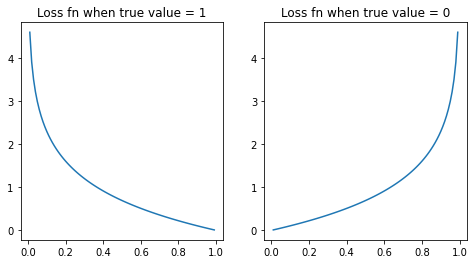

In [2]:
tvec = np.linspace(.01,.99,99)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(tvec, np.log(1/tvec))
plt.title('Loss fn when true value = 1')

plt.subplot(1,2,2)
plt.plot(tvec, np.log(1/(1-tvec)))
plt.title('Loss fn when true value = 0');


## Detailed steps
- Let $M_0$ be the current model
- Let $y_0$ be the current model's predictions on the training set
    - These will be point estimates for regression
    - These will be predicted probabilities for classification
- Let $y_t$ be the true answers (numbers for regression, 0/1 for classification)
- Let $L(y_{true}, y_{pred})$ be the loss function.
- Let $L^{\prime}_{y_{true}}(y_{pred}) = \frac{\partial}{\partial y_{pred}}(L(y_{true}, y_{pred}))$
- Let $z = L^{\prime}_{y_t}(y_1)$ -- i.e. the derivative of the loss function (with respect to the prediction) evaluated at each pair of (true, predicted) values.
- Finally, fit a decision tree that tries to predict $z$ using your predictors $X$.
    - Call the resulting tree $T_1$.
- Let $M_1 = M_0 + \epsilon T_1$ (epsilon is the "learning rate")
- Repeat with $M_1$ as the current model to build $T_2$  (etc. etc.)


### Alternate interpretation: 
- We are doing "gradient descent" by building trees

### Gradient Boosting Hyperparameter Optimization
In this section, we will review many of the hyperparameters, how they affect the building of the trees / forest, and different approaches to tuning them.  We will also demonstrate the `hyperopt` package and discuss approaches to parameter tuning.

In [3]:
#!pip install -I xgboost==1.4.2
#!pip install -I pandas==1.3.0

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss
import xgboost as xgb
xgb.__version__, pd.__version__  ## May give annoying warnings with newer versions than xgb 1.4.2, pandas 1.3.0

('1.4.2', '1.3.0')

In [5]:
pd.options.display.max_columns = 999

## Ames Housing Data

We'll start by using the Ames housing data.

In [6]:
# if using Google Colab, try:
# url = 'https://github.com/numeristical/resources/blob/master/GBIP/data/Ames_Housing_Data.tsv?raw=true'
# df_house = pd.read_csv(url, delimiter='\t')



In [6]:
df_house = pd.read_csv('../GBIP/data/Ames_Housing_Data.tsv', delimiter='\t')
df_house = df_house.loc[df_house['Gr Liv Area']<=4000,:]
df_house['Garage Area'].fillna(0, inplace=True)
df_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2925 non-null   int64  
 1   PID              2925 non-null   int64  
 2   MS SubClass      2925 non-null   int64  
 3   MS Zoning        2925 non-null   object 
 4   Lot Frontage     2435 non-null   float64
 5   Lot Area         2925 non-null   int64  
 6   Street           2925 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2925 non-null   object 
 9   Land Contour     2925 non-null   object 
 10  Utilities        2925 non-null   object 
 11  Lot Config       2925 non-null   object 
 12  Land Slope       2925 non-null   object 
 13  Neighborhood     2925 non-null   object 
 14  Condition 1      2925 non-null   object 
 15  Condition 2      2925 non-null   object 
 16  Bldg Type        2925 non-null   object 
 17  House Style   

In [7]:
df_house.sample(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
548,549,531452070,120,RL,50.0,7175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,TwnhsE,1Story,6,5,1990,1991,Gable,CompShg,Plywood,ImStucc,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1332.0,1332.0,GasA,Gd,Y,SBrkr,1332,0,0,1332,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1990.0,RFn,2.0,542.0,TA,TA,Y,0,60,0,0,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal,145000
1179,1180,533250110,120,RL,22.0,11064,Pave,NaN,IR2,Lvl,AllPub,CulDSac,Gtl,Veenker,Norm,Norm,TwnhsE,1Story,8,5,1995,1995,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,PConc,Gd,TA,Gd,LwQ,560.0,GLQ,670.0,0.0,1230.0,GasA,Ex,Y,SBrkr,1239,0,0,1239,1.0,0.0,1,1,1,1,Gd,4,Typ,1,Fa,Attchd,1995.0,Fin,2.0,477.0,TA,TA,Y,172,24,0,0,0,0,NaN,NaN,NaN,0,8,2008,WD,Normal,217500
1489,1490,908103260,85,RL,64.0,12102,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,SFoyer,5,5,1976,1976,Gable,CompShg,HdBoard,Plywood,BrkFace,222.0,TA,TA,CBlock,Gd,Gd,Gd,ALQ,456.0,Unf,0.0,0.0,456.0,GasA,Ex,Y,SBrkr,1033,0,0,1033,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,BuiltIn,1976.0,RFn,2.0,504.0,Fa,TA,Y,224,0,0,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Family,165000
1409,1410,905427070,70,RL,120.0,13728,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,2Story,6,7,1935,1986,Hip,CompShg,Stucco,Stucco,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,626.0,Unf,0.0,501.0,1127.0,GasA,Ex,Y,SBrkr,1236,872,0,2108,0.0,0.0,2,0,4,1,Gd,7,Typ,2,TA,Basment,1935.0,Unf,2.0,540.0,TA,TA,Y,0,0,0,0,90,0,NaN,NaN,NaN,0,7,2008,WD,Normal,235000
2245,2246,911370450,120,RM,59.0,5568,Pave,NaN,IR1,HLS,AllPub,Inside,Mod,Crawfor,Norm,Norm,TwnhsE,1Story,8,5,2006,2007,Hip,CompShg,CemntBd,CmentBd,Stone,473.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,1573.0,Unf,0.0,0.0,1573.0,GasA,Gd,Y,SBrkr,1625,0,0,1625,1.0,1.0,2,0,2,1,Gd,5,Typ,1,Gd,Attchd,2006.0,Fin,2.0,495.0,TA,TA,Y,123,0,0,0,153,0,NaN,NaN,NaN,0,10,2007,New,Partial,375000


In [8]:
df_house.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [9]:
feat_1 = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces']


In [10]:
X = df_house.iloc[:,:-1]  # everything except Sale Price
y = df_house.SalePrice 

In [11]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,test_size = 400, random_state=0)

In [12]:
X.loc[:,feat_1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2925 non-null   int64  
 1   Overall Qual    2925 non-null   int64  
 2   Overall Cond    2925 non-null   int64  
 3   Year Built      2925 non-null   int64  
 4   Year Remod/Add  2925 non-null   int64  
 5   Gr Liv Area     2925 non-null   int64  
 6   Full Bath       2925 non-null   int64  
 7   Half Bath       2925 non-null   int64  
 8   Bedroom AbvGr   2925 non-null   int64  
 9   Garage Area     2925 non-null   float64
 10  Fireplaces      2925 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 274.2 KB


### Brief Data Exploration
It is a good habit to look at the data before modeling.  For regression the `pairplot` in the seaborn package is a nice way to look at all of the bivariate relationships.  You should also understand distribution of the target variable (and know its mean).

In [13]:
np.mean(df_house.SalePrice)

180411.5747008547

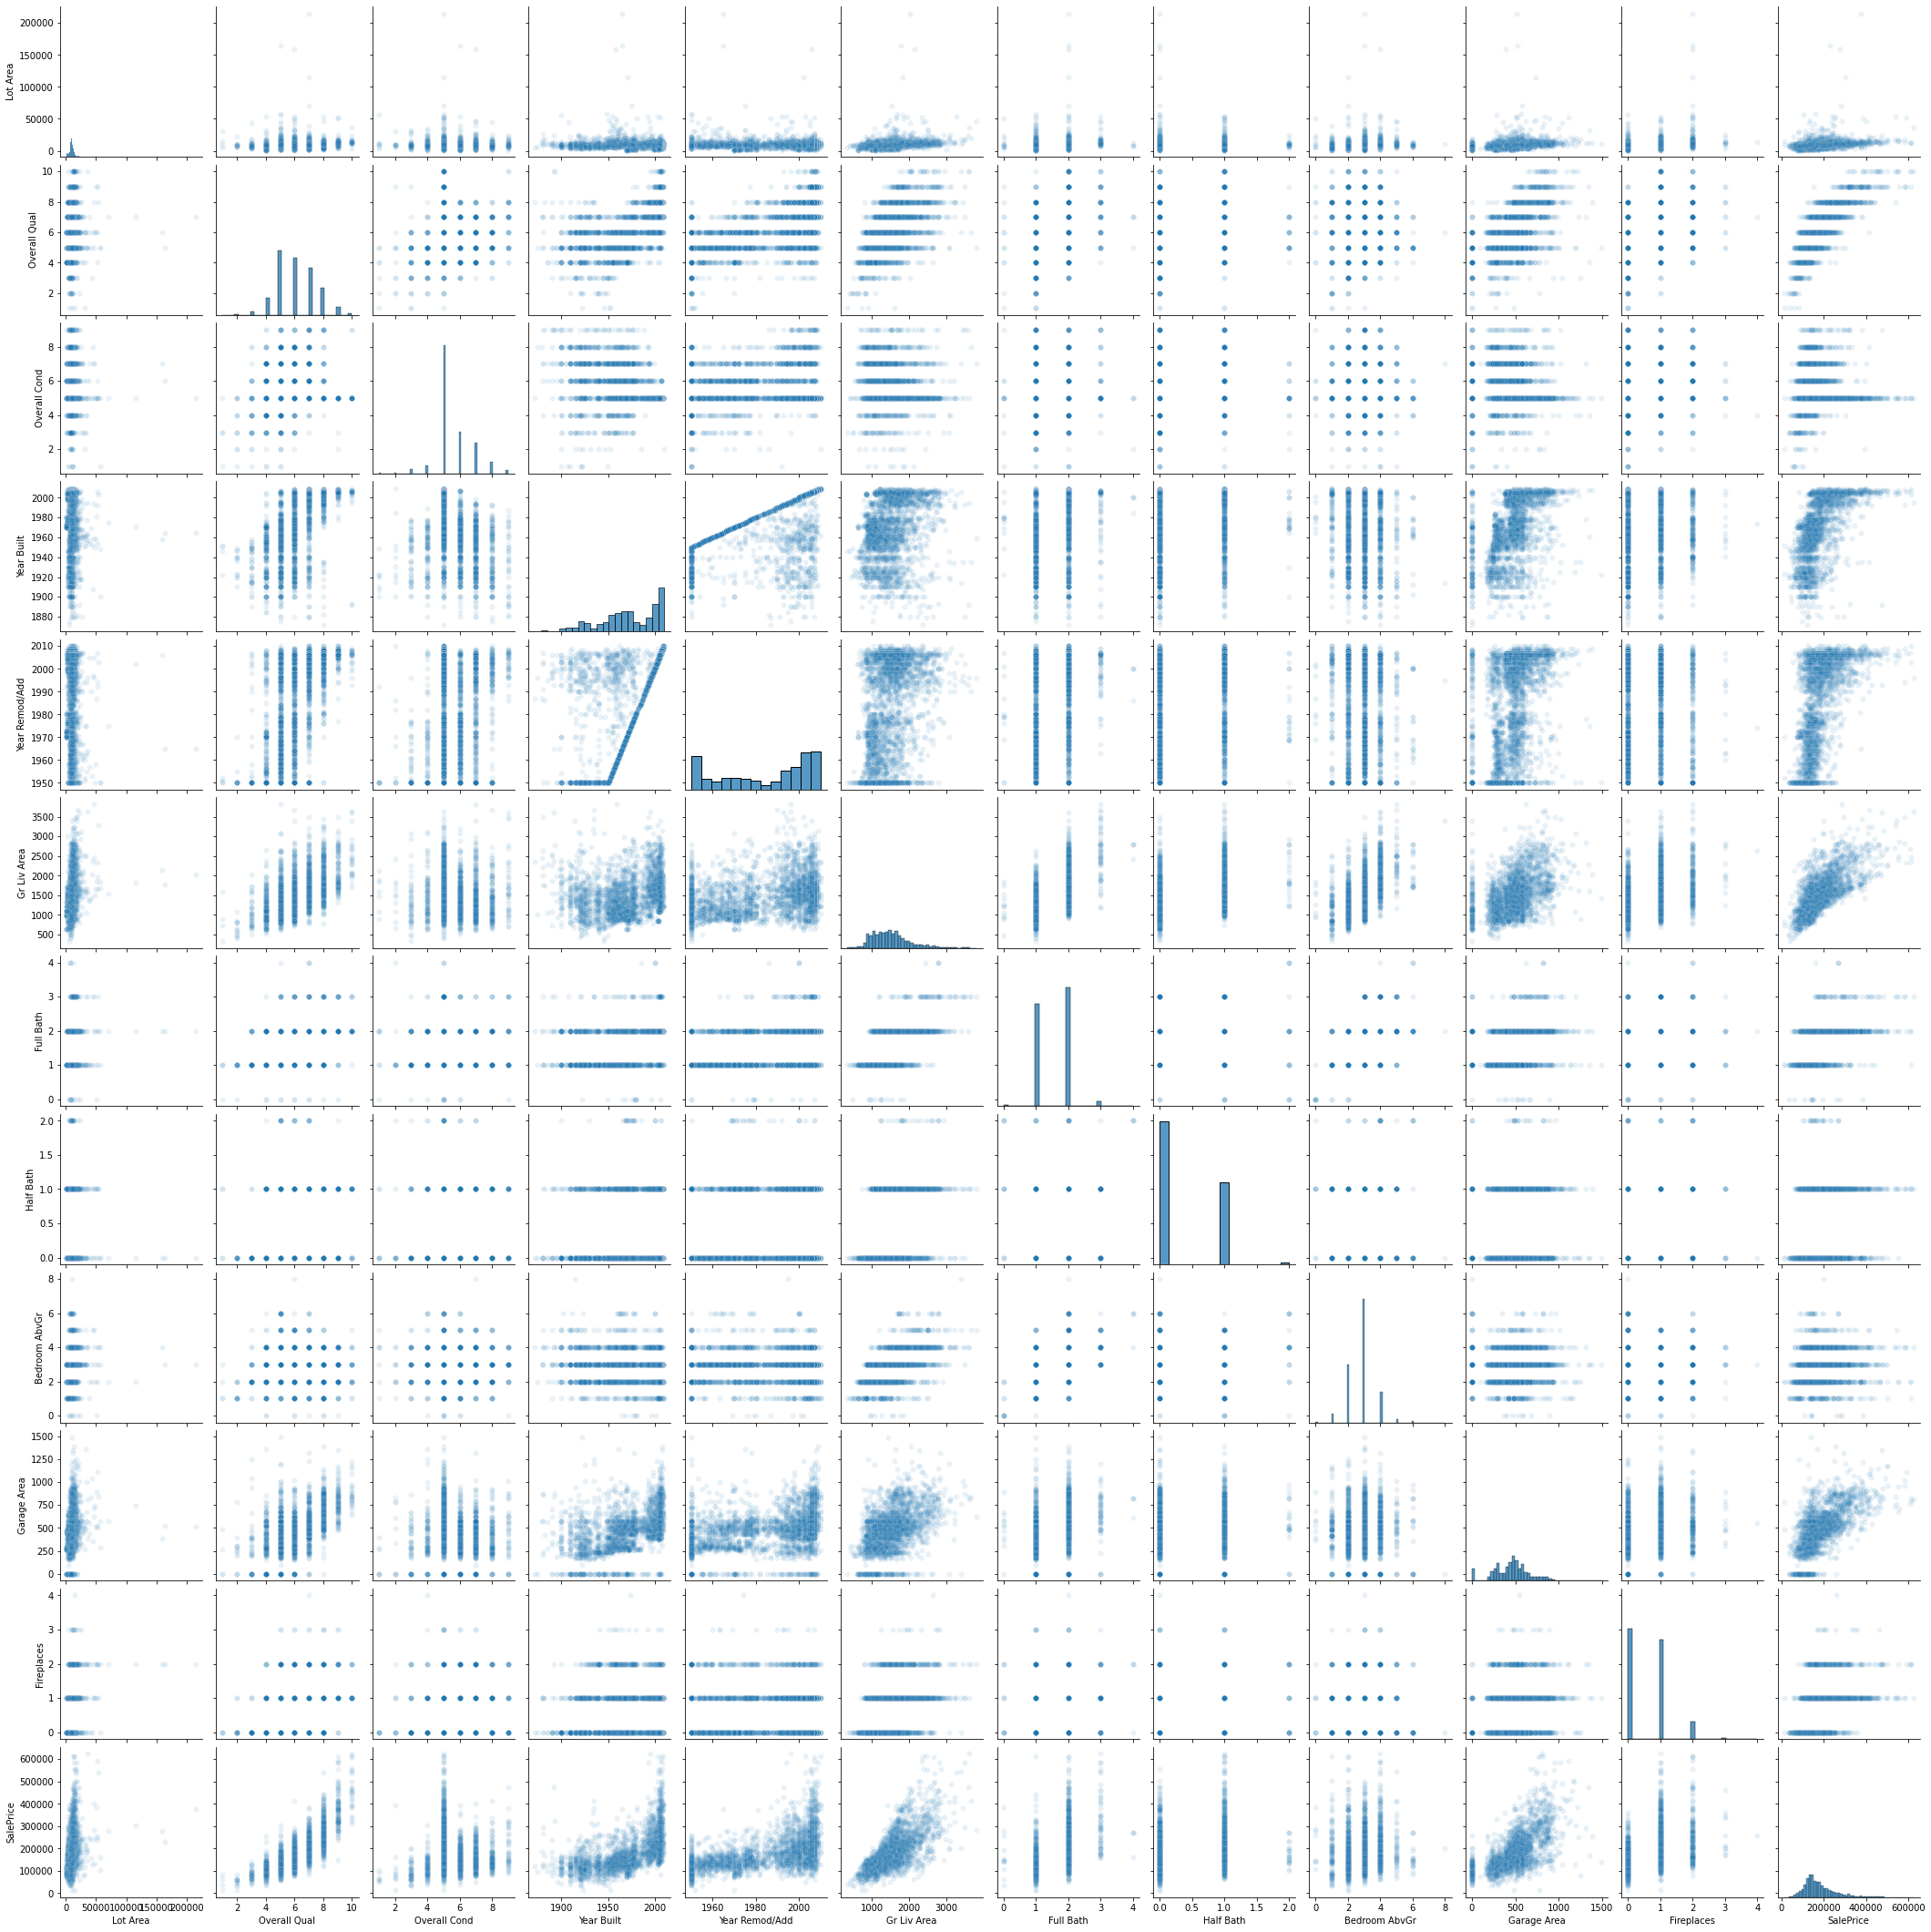

In [14]:
import seaborn as sns
sns.pairplot(df_house.loc[:,feat_1+['SalePrice']], plot_kws={'alpha':.1})

## Exercise
- What variables seem to have the strongest relationship with the SalePrice?
- What is going on with 'Year Built' and 'Year Remod/Add'?

In [15]:
X_train_1 = X_train_full.loc[:, feat_1]
y_train_1 = y_train_full
X_test_1 = X_test.loc[:, feat_1]

In [16]:
## Let's start with a random forest to set a baseline

In [17]:
rf1 = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf1

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [18]:
rf1.fit(X_train_1, y_train_1)

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [19]:
preds_rf1 = rf1.predict(X_test_1)

In [20]:
np.sqrt(mean_squared_error(y_test, preds_rf1)), mean_absolute_error(y_test, preds_rf1)

(23161.992179943794, 16067.050036369044)

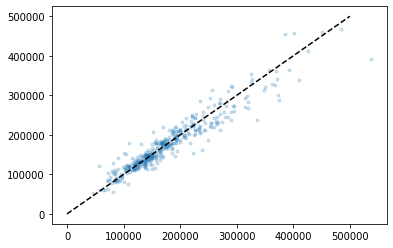

In [21]:
plt.scatter(y_test, preds_rf1, alpha=.2, marker='.')
plt.plot([0,500000],[0,500000], 'k--')

## XGBoost
XGBoost first came out in 2015.  The acronym is "eXtreme Gradient Boosting".  It implemented a number of theoretical and practical improvements, many of which have become standard in subsequent packages:

- *Native handling of missing data*: (Missing values are checked to see if they "fit" better on the left or right side of the tree for each split values)
- *Newton steps*: rather than just finding the gradient, XGBoost also looks at the second derivative to determine the step size.
- *Advanced Regularization*: XGBoost rederived the math to flexibly incorporate *shrinkage* (similar to Lasso/Ridge Regression) and penalize the number of splits.
- *Not checking every split*: XGBoost had a method for deriving quantiles to avoid checking every split (particularly in large datasets when a predictor has a large number of possible values).  Though not the default, this has since been shown to be effective both for speeding up the training *and* as another source of regularization
- *Distributed training*: XGBoost had implementations for working with large datasets that are not held in memory.

In [22]:
xgb_def = xgb.XGBRegressor()
xgb_def

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [23]:
xgb_def.fit(X_train_1, y_train_1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
preds_xgb_def = xgb_def.predict(X_test_1)

In [25]:
np.sqrt(mean_squared_error(y_test, preds_xgb_def)), mean_absolute_error(y_test, preds_xgb_def)


(23693.223543591423, 16741.70330078125)

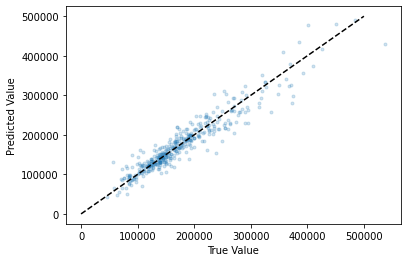

In [26]:
plt.scatter(y_test, preds_xgb_def, alpha=.2, marker='.')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.plot([0,500000],[0,500000], 'k--')

## Hyperparameter Optimization - Practical Considerations
- How much is it worth to improve (metric) by x ? (From a business / practical point of view)
- How much time / computing do I want to spend on improvement?
- How often will I be re-training / re-implementing this model?
- What is the value of knowing / understanding this dataset / model really well?


## Boosting Parameters

- The three most important parameters in your boosting model are the *max_depth*, *learning_rate*, and *n_estimators*.  
- Setting these is made more challenging by the fact that they are highly interactive
- The best way to handle this is:
    - Set aside a validation set for early stopping
    - Use a low `learning rate`
    - Use a high `n_estimators` (we will early stop)
    - Stop when performance on the validation set begins to degrade
    
XGBoost makes it easy to implement early stopping, as we demonstrate below:


In [27]:
xgb1 = xgb.XGBRegressor(n_estimators=5000, learning_rate=.01)
xgb1

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [28]:
xgb1.fit(X_train_1, y_train_1, 
         eval_set=[(X_test_1, y_test)], 
        early_stopping_rounds = 10)

[0]	validation_0-rmse:190622.93750
[1]	validation_0-rmse:188799.15625
[2]	validation_0-rmse:186988.57812
[3]	validation_0-rmse:185196.73438
[4]	validation_0-rmse:183442.81250
[5]	validation_0-rmse:181691.14062
[6]	validation_0-rmse:179967.46875
[7]	validation_0-rmse:178238.40625
[8]	validation_0-rmse:176540.64062
[9]	validation_0-rmse:174861.68750
[10]	validation_0-rmse:173203.03125
[11]	validation_0-rmse:171558.98438
[12]	validation_0-rmse:169934.59375
[13]	validation_0-rmse:168310.43750
[14]	validation_0-rmse:166720.46875
[15]	validation_0-rmse:165134.42188
[16]	validation_0-rmse:163563.96875
[17]	validation_0-rmse:162017.00000
[18]	validation_0-rmse:160483.75000
[19]	validation_0-rmse:158970.17188
[20]	validation_0-rmse:157458.84375
[21]	validation_0-rmse:155976.31250
[22]	validation_0-rmse:154511.64062
[23]	validation_0-rmse:153060.26562
[24]	validation_0-rmse:151621.29688
[25]	validation_0-rmse:150206.25000
[26]	validation_0-rmse:148796.89062
[27]	validation_0-rmse:147398.57812
[2

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
preds_xgb1 = xgb1.predict(X_test_1)

In [30]:
np.sqrt(mean_squared_error(y_test, preds_xgb1)), mean_absolute_error(y_test, preds_xgb1)

(22846.39744738254, 15921.43888671875)

In [31]:
# Compared to last model
np.sqrt(mean_squared_error(y_test, preds_xgb_def)), mean_absolute_error(y_test, preds_xgb_def)

(23693.223543591423, 16741.70330078125)

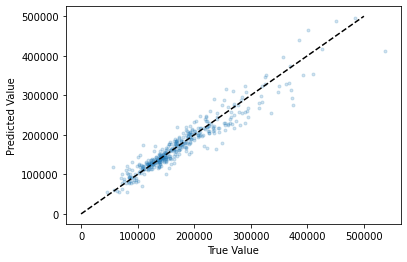

In [32]:
plt.scatter(y_test, preds_xgb1, alpha=.2, marker='.')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.plot([0,500000],[0,500000], 'k--')

In [33]:
md_vals_vec=list(range(1,9))
rmse_vec = np.zeros(len(md_vals_vec))
for i,md in enumerate(md_vals_vec):
    xgb_temp = xgb.XGBRegressor(max_depth=md, 
                        n_estimators=5000, learning_rate=.01) #, early_stopping_rounds=10)
    xgb_temp.fit(X_train_1, y_train_1, 
         eval_set=[(X_test_1, y_test)], 
         early_stopping_rounds = 10, 
                 verbose=0)
    preds = xgb_temp.predict(X_test_1)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))
    
## Note - for newer versions of xgboost, this might scream at you....


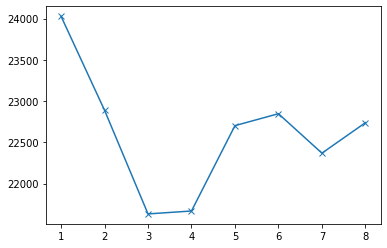

In [34]:
# Plot performance vs. max_depth
plt.plot(md_vals_vec, rmse_vec, marker='x')

### Other boosting parameters
Thus far we have focused our attention on the `max_depth`, `learning_rate`, and `n_estimators`.  Indeed, these are the most important parameters to get right.  However, there are other parameters that can yield improvements if tuned appropriately.  These parameters fall into several groups, and different packages handle them (and name them) differently.


#### Data (row) sampling parameters
How to choose the data for each tree.  Unlike Random Forest, "Standard" boosting just uses the whole data set for each tree.  However, you can choose to sample the data (with or without replacement) to add regularization.
- subsample, replacement, etc.

#### Feature sampling parameters
Unlike Random Forest, the default in gradient boosting is to check every feature at every node.  Since boosting is not relying on having uncorrelated trees, it can still give good results without this randomization.  However, randomly sampling features can help regularize, in addition to speeding up training (it is faster to train if you don't check every column every time). Some packages permit subsampling features per tree, level, *and* node.
- Examples: colsample_bynode, colsample_bytree, colsample_bylevel

#### Split sampling parameters
For each feature, should we check all possible splits, or reduce the number somehow
- Examples: tree_method, sketch_eps in XGBoost



#### Regularization parameters
Other regularization parameters include:
- minimum "improvement" required to make a split
- "Shrinkage" of the leaf values of the trees (as in LASSO / Ridge regression)
- gamma, reg_lambda, reg_alpha



## Setting Parameters in Gradient Boosting
There are several approaches to finding the best parameters for your Gradient Boosting Model
1. Do a massive "grid search"
2. Just play around manually
3. "Smart" parameter search that tries to search promising combinations

There are drawbacks to all of these:
- Grid search is extremely time consuming
- It is difficult to know if you are choosing appropriate parameters and ranges
- There may be other considerations than just metric performance (model size, coherence, training time)
- Manual approaches are haphazard, attention consuming
- Smart approaches are not always as smart as they could be

## Suggested hybrid approach
1. Use early stopping, low learning rate, high number of trees (to remove learning rate and number of estimators from the search)
1. Run hyperopt with a few parameters (including max_depth) to "understand the landscape"
1. Iteratively refine your ranges and add more parameters to the search

#### Summary: Look around *before* doing long iterations

## Let's manually explore some parameters one by one...

In [35]:
# Look at subsample first
param_vals_vec=[.7,.75,.8,.85,.9,.95,1]
rmse_vec = np.zeros(len(param_vals_vec))
for i,param_val in enumerate(param_vals_vec):
    xgb_temp = xgb.XGBRegressor(max_depth=3, 
                        n_estimators=10000, learning_rate=.01,
                        subsample=param_val)
    xgb_temp.fit(X_train_1, y_train_1, 
         eval_set=[(X_test_1, y_test)], 
        early_stopping_rounds = 10, 
                 verbose=0)
    preds = xgb_temp.predict(X_test_1)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))

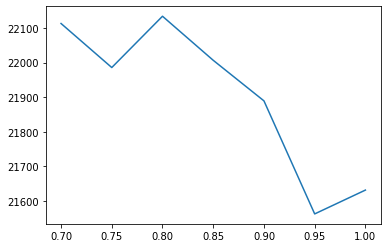

In [36]:
plt.plot(param_vals_vec, rmse_vec)

In [37]:
# Look at subsample first
param_vals_vec=[.7,.75,.8,.85,.9,.95,1]
rmse_vec = np.zeros(len(param_vals_vec))
for i,param_val in enumerate(param_vals_vec):
    xgb_temp = xgb.XGBRegressor(max_depth=4, 
                        n_estimators=10000, learning_rate=.01,
                        subsample=param_val) #, early_stopping_rounds = 10)
    xgb_temp.fit(X_train_1, y_train_1, 
         eval_set=[(X_test_1, y_test)], 
        early_stopping_rounds = 10, 
                 verbose=0)
    preds = xgb_temp.predict(X_test_1)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))

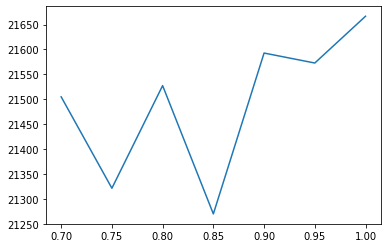

In [38]:
plt.plot(param_vals_vec, rmse_vec)

In [39]:
# Let's set md 4, subsample .85
# and look at the colsample params
param_vals_vec=[.2, .4, .6, .8, 1]
rmse_vec = np.zeros(len(param_vals_vec))
for i,param_val in enumerate(param_vals_vec):
    xgb_temp = xgb.XGBRegressor(max_depth=4, 
                        n_estimators=10000, learning_rate=.01,
                        subsample=.85, colsample_bynode=param_val)#, early_stopping_rounds = 10)
    xgb_temp.fit(X_train_1, y_train_1, 
         eval_set=[(X_test_1, y_test)], 
         early_stopping_rounds = 10, 
                 verbose=0)
    preds = xgb_temp.predict(X_test_1)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))

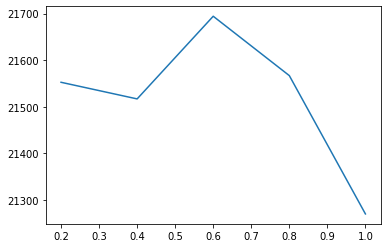

In [40]:
plt.plot(param_vals_vec, rmse_vec)

In [41]:
# Let's set md 4, subsample .85
# now look at the regularization params
param_vals_vec=[1, 2, 3, 5, 10, 20]
rmse_vec = np.zeros(len(param_vals_vec))
for i,param_val in enumerate(param_vals_vec):
    xgb_temp = xgb.XGBRegressor(max_depth=4, 
                        n_estimators=10000, learning_rate=.01,
                        subsample=.85, reg_lambda=param_val)#, early_stopping_rounds = 10)
    xgb_temp.fit(X_train_1, y_train_1, 
         eval_set=[(X_test_1, y_test)], 
         early_stopping_rounds = 10, 
                 verbose=0)
    preds = xgb_temp.predict(X_test_1)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))

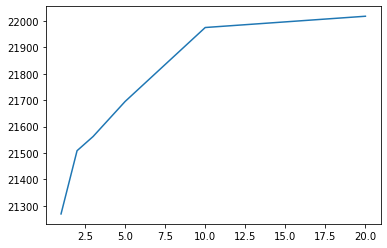

In [42]:
plt.plot(param_vals_vec, rmse_vec)

### Hyperopt Package
Idea: rather than try and exhaustively search a huge parameter space, focus the search on "promising" areas of the search space (based on what you have seen so far).

The `hyperopt` package can be a bit confusing and has some limitations, but overall does a reasonably good job of seraching the parameter space.

Let's see it in action

In [43]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

- First we must define the "loss function"
- This takes a set of parameters and output the loss value

In [44]:
def eval_model(params):
    xgb_base = xgb.XGBRegressor()
    xgb_base.set_params(**params)
    xgb_base.fit(X_train_1, y_train_1, eval_set=[(X_test_1, y_test)], 
                 early_stopping_rounds=20, eval_metric='logloss',
                 verbose=False)
    preds = xgb_base.predict(X_test_1)
    return(np.sqrt(mean_squared_error(y_test, preds)))

- Next, we define the parameter space.  
- There are several options to define ranges.
    - `randint`: chooses a random integer between a lower and an upper bound
    - `choice`: choose from a set of specific values
    - `uniform`: choose a (float) in the range
    - `quniform`: choose a discrete range of floats
    
See more at hyperopt documentation:
http://hyperopt.github.io/hyperopt/getting-started/search_spaces/


In [45]:
fspace1 = {
    'max_depth':hp.randint('max_depth', 2, 5), # Pythonic - means 2 through 4 inclusive
    'colsample_bynode': hp.uniform('colsample_bynode',.2,1),
    'subsample': hp.quniform('subsample',.3,1,.05),
    'learning_rate':.01,
    'n_estimators': 10000,
#    'eval_metric': 'logloss',
#    'early_stopping_rounds': 20
}

- Finally, we use the `fmin` function and record our trials in a `Trials` object
- you can also specify which algorithm to use (http://hyperopt.github.io/hyperopt/#algorithms) (`tpe.suggest` is "Tree of Parzen Estimators") 


In [46]:
trials1 = Trials()
best = fmin(fn=eval_model, space=fspace1, algo=tpe.suggest, max_evals=1000, trials=trials1)

100%|██████| 1000/1000 [02:06<00:00,  7.88trial/s, best loss: 190613.9450194423]


In [47]:
best

{'colsample_bynode': 0.3643640745060255, 'max_depth': 4, 'subsample': 0.4}

In [48]:
trials1.trials[:2]

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 190636.3024674548, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bynode': [0], 'max_depth': [0], 'subsample': [0]},
   'vals': {'colsample_bynode': [0.2761245426037743],
    'max_depth': [4],
    'subsample': [0.4]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2022, 10, 28, 21, 30, 46),
  'refresh_time': datetime.datetime(2022, 10, 28, 21, 30, 46, 111000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': 190682.9396424911, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bynode': [1], 'max_depth': [1], 'subsample': [1]},
   'vals': {'colsample_bynode': [0.35724573131410076],
    'max_depth': [3],
    'subsample': [0.7000000000000001]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time

In [49]:
md_trial_vals = np.array([t['misc']['vals']['max_depth'] for t in trials1.trials])
csbn_trial_vals = np.array([t['misc']['vals']['colsample_bynode'] for t in trials1.trials])
ss_trial_vals = np.array([t['misc']['vals']['subsample'] for t in trials1.trials])
loss_trial_vals = np.array([t['result']['loss'] for t in trials1.trials])
trial_nums = np.array([t['tid'] for t in trials1.trials])

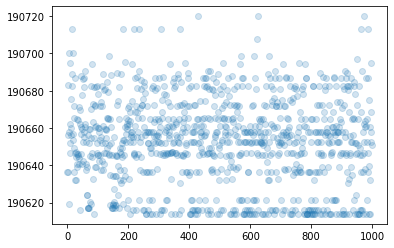

In [50]:
plt.scatter(trial_nums, loss_trial_vals, alpha=.2)

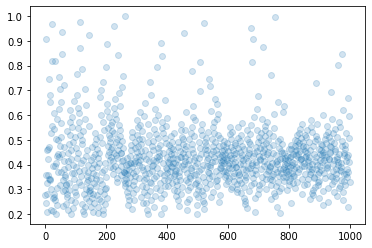

In [51]:
plt.scatter(trial_nums, csbn_trial_vals, alpha=.2)

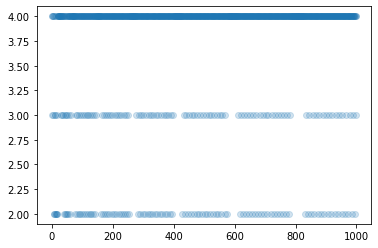

In [52]:
plt.scatter(trial_nums, md_trial_vals, alpha=.2)

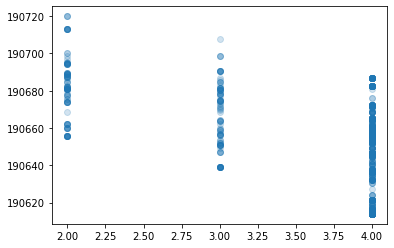

In [53]:
plt.scatter(md_trial_vals, loss_trial_vals, alpha=.2)

Based on the above, how might you change the ranges for these parameters next time?

## Your turn - use the template below to do another parameter search
1. Update the range for one of the previous parameters
2. Add `gamma`, `reg_alpha`, and `reg_lambda` to the search (and any other parameters you wish)
3. Let it run for 1500 iterations
4. Do some plotting and exploring to understand which parameter combinations worked best

In [54]:
# fspace2 = {
#     'max_depth':hp.randint('max_depth', 5), # goes up to 5-1
#     'colsample_bynode': hp.uniform('colsample_bynode',.2,1),
#     'subsample': hp.quniform('subsample',.3,1,.05),

#     'gamma': 
#     'reg_alpha': 
#     'reg_lambda': 
#     'learning_rate':.01,
#     'n_estimators': 10000
# }

In [55]:
# trials2 = Trials()
# best = fmin(fn=eval_model, space=fspace2, algo=tpe.suggest, max_evals=1500, trials=trials2)


# Final comments on parameter search
- This example was a quite small dataset (~4500 data points), so we were able to run many iterations very quickly.  Typically these searches will take much longer, so it is more important to choose smart ranges.
- Note that lots of combinations gave very good results.  Typically if you get the `max_depth` right (using early stopping) and then pick "pretty good" values for the rest, you will be in good shape
- In practice, other considerations (e.g. model size, parsimony) may come into play.  Generally, you want to pick a "simpler" model if the difference in performance is negligible

# Review of Gradient Boosting Packages
Next we will review LightGBM, CatBoost, and StructureBoost, and discuss their capabilities and limitations.  This is included for your benefit, we may not go through this section during the workshop/

## LightGBM
LightGBM came out around 2017 (was in NeurIPS 2017), written mainly by researchers at Microsoft Research.  Its major advances are the following:
- smarter techniques (by default) to avoid searching all splits and speeding things up (ignoring small gradients to reduce data at each iteration)
- "looks for" mutually exclusive features to handle them better
- handles categorical variables by ranking their marginal target value in each node
- categorical variables *must* be integer encoded

In [56]:
import lightgbm as lgbm

In [57]:
lgbm.LGBMRegressor?

Init signature:
lgbm.LGBMRegressor(
    boosting_type: str = 'gbdt',
    num_leaves: int = 31,
    max_depth: int = -1,
    learning_rate: float = 0.1,
    n_estimators: int = 100,
    subsample_for_bin: int = 200000,
    objective: Union[str, Callable, NoneType] = None,
    class_weight: Union[Dict, str, NoneType] = None,
    min_split_gain: float = 0.0,
    min_child_weight: float = 0.001,
    min_child_samples: int = 20,
    subsample: float = 1.0,
    subsample_freq: int = 0,
    colsample_bytree: float = 1.0,
    reg_alpha: float = 0.0,
    reg_lambda: float = 0.0,
    random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None,
    n_jobs: int = -1,
    silent: Union[bool, str] = 'warn',
    importance_type: str = 'split',
    **kwargs,
)
Docstring:      LightGBM regressor.
Init docstring:
Construct a gradient boosting model.

Parameters
----------
boosting_type : str, optional (default='gbdt')
    'gbdt', traditional Gradient Boosting Decision Tree.
    'dart', Dr

In [58]:
lgbm1 = lgbm.LGBMRegressor(n_estimators=10000, learning_rate=.01, max_depth=4, subsample=.85)

In [59]:
lgbm1.fit(X_train_1, y_train_1, eval_set=[(X_test_1, y_test)],
                          early_stopping_rounds=10)

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 5.42802e+09
[2]	valid_0's l2: 5.34683e+09
[3]	valid_0's l2: 5.26695e+09
[4]	valid_0's l2: 5.18868e+09
[5]	valid_0's l2: 5.11208e+09
[6]	valid_0's l2: 5.03661e+09
[7]	valid_0's l2: 4.96285e+09
[8]	valid_0's l2: 4.89035e+09
[9]	valid_0's l2: 4.8192e+09
[10]	valid_0's l2: 4.74948e+09
[11]	valid_0's l2: 4.68142e+09
[12]	valid_0's l2: 4.61455e+09
[13]	valid_0's l2: 4.54855e+09
[14]	valid_0's l2: 4.48407e+09
[15]	valid_0's l2: 4.42109e+09
[16]	valid_0's l2: 4.35909e+09
[17]	valid_0's l2: 4.29736e+09
[18]	valid_0's l2: 4.23737e+09
[19]	valid_0's l2: 4.17863e+09
[20]	valid_0's l2: 4.12211e+09
[21]	valid_0's l2: 4.06557e+09
[22]	valid_0's l2: 4.01075e+09
[23]	valid_0's l2: 3.95656e+09
[24]	valid_0's l2: 3.9026e+09
[25]	valid_0's l2: 3.84981e+09
[26]	valid_0's l2: 3.79732e+09
[27]	valid_0's l2: 3.74662e+09
[28]	valid_0's l2: 3.69576e+09
[29]	valid_0's l2: 3.64626e+09
[30]	valid_0's l2: 3.59718e+09
[31]	valid_0's l2: 3.54877e+09
[32]	valid_0's l2: 3.50244e+09
[33]	valid_0's l2: 

LGBMRegressor(learning_rate=0.01, max_depth=4, n_estimators=10000,
              subsample=0.85)

In [60]:
lgbm1_preds = lgbm1.predict(X_test_1)
np.sqrt(mean_squared_error(y_test, lgbm1_preds))

21451.78955405113

In [61]:
feat_2 = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces','Neighborhood']


In [62]:
X_train_2 = X_train_full.loc[:, feat_2]
y_train_2 = y_train_full
X_test_2 = X_test.loc[:, feat_2]

In [63]:
X_train_2.Neighborhood.value_counts()

NAmes      380
CollgCr    235
OldTown    206
Edwards    167
Somerst    154
NridgHt    145
Gilbert    141
Sawyer     130
NWAmes     115
SawyerW    112
Mitchel    100
BrkSide     95
Crawfor     85
IDOTRR      81
Timber      62
NoRidge     59
StoneBr     42
ClearCr     40
SWISU       40
BrDale      28
MeadowV     28
Blmngtn     21
NPkVill     21
Veenker     20
Greens       8
Blueste      7
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

In [64]:
mapping_dict = {neigh_name:i for i,neigh_name in enumerate(df_house.Neighborhood.unique())}
mapping_dict

{'NAmes': 0,
 'Gilbert': 1,
 'StoneBr': 2,
 'NWAmes': 3,
 'Somerst': 4,
 'BrDale': 5,
 'NPkVill': 6,
 'NridgHt': 7,
 'Blmngtn': 8,
 'NoRidge': 9,
 'SawyerW': 10,
 'Sawyer': 11,
 'Greens': 12,
 'BrkSide': 13,
 'OldTown': 14,
 'IDOTRR': 15,
 'ClearCr': 16,
 'SWISU': 17,
 'Edwards': 18,
 'CollgCr': 19,
 'Crawfor': 20,
 'Blueste': 21,
 'Mitchel': 22,
 'Timber': 23,
 'MeadowV': 24,
 'Veenker': 25,
 'GrnHill': 26,
 'Landmrk': 27}

In [65]:
X_train_2a = X_train_2.copy()
X_test_2a = X_test_2.copy()

X_train_2a['Neighborhood'] = X_train_2['Neighborhood'].map(lambda x: mapping_dict[x])
X_test_2a['Neighborhood'] = X_test_2['Neighborhood'].map(lambda x: mapping_dict[x])


In [66]:
# try md4 then md3
lgbm2 = lgbm.LGBMRegressor(n_estimators=10000, learning_rate=.01, max_depth=4, subsample=.85, 
                           categorical_feature='name:Neighborhood',
                          num_leaves = 64)

Note: the warnings below are a known issue and hopefully will be resolved in a future version. (See https://github.com/microsoft/LightGBM/issues/3379)

In [67]:
lgbm2.fit(X_train_2a, y_train_2, eval_set=[(X_test_2a, y_test)], categorical_feature=['Neighborhood'],
         early_stopping_rounds=10)

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Neighborhood']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/lightgbm/basic.py:1487: Us

[1]	valid_0's l2: 5.42699e+09
[2]	valid_0's l2: 5.344e+09
[3]	valid_0's l2: 5.26319e+09
[4]	valid_0's l2: 5.18325e+09
[5]	valid_0's l2: 5.10559e+09
[6]	valid_0's l2: 5.0294e+09
[7]	valid_0's l2: 4.95419e+09
[8]	valid_0's l2: 4.88098e+09
[9]	valid_0's l2: 4.80806e+09
[10]	valid_0's l2: 4.73633e+09
[11]	valid_0's l2: 4.66693e+09
[12]	valid_0's l2: 4.59794e+09
[13]	valid_0's l2: 4.53106e+09
[14]	valid_0's l2: 4.46539e+09
[15]	valid_0's l2: 4.40212e+09
[16]	valid_0's l2: 4.33831e+09
[17]	valid_0's l2: 4.27724e+09
[18]	valid_0's l2: 4.2164e+09
[19]	valid_0's l2: 4.15602e+09
[20]	valid_0's l2: 4.09872e+09
[21]	valid_0's l2: 4.04097e+09
[22]	valid_0's l2: 3.98509e+09
[23]	valid_0's l2: 3.92915e+09
[24]	valid_0's l2: 3.87516e+09
[25]	valid_0's l2: 3.82179e+09
[26]	valid_0's l2: 3.76936e+09
[27]	valid_0's l2: 3.7184e+09
[28]	valid_0's l2: 3.66596e+09
[29]	valid_0's l2: 3.61588e+09
[30]	valid_0's l2: 3.56518e+09
[31]	valid_0's l2: 3.51765e+09
[32]	valid_0's l2: 3.47138e+09
[33]	valid_0's l2: 3.4

LGBMRegressor(categorical_feature='name:Neighborhood', learning_rate=0.01,
              max_depth=4, n_estimators=10000, num_leaves=64, subsample=0.85)

In [68]:
lgbm2_preds = lgbm2.predict(X_test_2a)
np.sqrt(mean_squared_error(y_test, lgbm2_preds))

21363.8962796525

## Catboost
Catboost came out around 2017-2018 (paper in NeurIPS 2018), written by a group of researchers at Yandex.  Its major advance was allowing *native handling of categorical variables* (as strings).  Specifically, it does on-the-fly *numerical encoding* of categorical variables, with a clever encoding scheme to reduce overfitting (their paper argues that the standard approach of LightGBM overfits).  It is also highly optimized, very fast.

In [69]:
import catboost as cb

In [70]:
cb1 = cb.CatBoostRegressor(n_estimators=10000, learning_rate=.01, max_depth=4,
                          early_stopping_rounds=10, eval_metric='RMSE', subsample=.85)

In [71]:
cb1.fit(X_train_1, y_train_1, eval_set=[(X_test_1, y_test)])

0:	learn: 78673.5672241	test: 73770.7736529	best: 73770.7736529 (0)	total: 58ms	remaining: 9m 40s
1:	learn: 78116.4190710	test: 73283.1910098	best: 73283.1910098 (1)	total: 60ms	remaining: 4m 59s
2:	learn: 77613.3151732	test: 72838.1760004	best: 72838.1760004 (2)	total: 61.1ms	remaining: 3m 23s
3:	learn: 77146.8460866	test: 72412.7692275	best: 72412.7692275 (3)	total: 62.1ms	remaining: 2m 35s
4:	learn: 76612.0544106	test: 71918.4061911	best: 71918.4061911 (4)	total: 64.1ms	remaining: 2m 8s
5:	learn: 76123.3155100	test: 71462.2589191	best: 71462.2589191 (5)	total: 65.4ms	remaining: 1m 48s
6:	learn: 75630.6081149	test: 71015.1854312	best: 71015.1854312 (6)	total: 66.6ms	remaining: 1m 35s
7:	learn: 75141.5519180	test: 70591.9787521	best: 70591.9787521 (7)	total: 68ms	remaining: 1m 24s
8:	learn: 74652.0339559	test: 70132.8546662	best: 70132.8546662 (8)	total: 69.2ms	remaining: 1m 16s
9:	learn: 74183.9445491	test: 69702.1462130	best: 69702.1462130 (9)	total: 70.5ms	remaining: 1m 10s
10:	lea

In [72]:
cb1_preds = cb1.predict(X_test_1)
np.sqrt(mean_squared_error(y_test, cb1_preds))

22000.001778396

In [73]:
X_train_2.Neighborhood.unique()

array(['CollgCr', 'Edwards', 'BrkSide', 'SWISU', 'NAmes', 'Somerst',
       'Sawyer', 'IDOTRR', 'NWAmes', 'BrDale', 'Crawfor', 'NridgHt',
       'Gilbert', 'Mitchel', 'Timber', 'Greens', 'SawyerW', 'StoneBr',
       'NoRidge', 'ClearCr', 'MeadowV', 'OldTown', 'Blmngtn', 'Veenker',
       'Blueste', 'NPkVill', 'Landmrk', 'GrnHill'], dtype=object)

In [74]:
## Try md 4 then md 6
cb2 = cb.CatBoostRegressor(n_estimators=10000, learning_rate=.01, max_depth=4,
                          early_stopping_rounds=100, eval_metric='RMSE', cat_features=['Neighborhood'])

In [75]:
cb2.fit(X_train_2, y_train_2, eval_set=[(X_test_2, y_test)])

0:	learn: 78694.4009027	test: 73768.4579489	best: 73768.4579489 (0)	total: 3.56ms	remaining: 35.6s
1:	learn: 78151.4843927	test: 73271.2664053	best: 73271.2664053 (1)	total: 7.01ms	remaining: 35s
2:	learn: 77612.5508372	test: 72772.1201893	best: 72772.1201893 (2)	total: 9.71ms	remaining: 32.3s
3:	learn: 77078.7882529	test: 72272.8284940	best: 72272.8284940 (3)	total: 11.8ms	remaining: 29.4s
4:	learn: 76553.7490509	test: 71771.7963596	best: 71771.7963596 (4)	total: 14.5ms	remaining: 28.9s
5:	learn: 76033.2526764	test: 71322.8844061	best: 71322.8844061 (5)	total: 17.3ms	remaining: 28.8s
6:	learn: 75526.6408508	test: 70890.2784227	best: 70890.2784227 (6)	total: 20ms	remaining: 28.5s
7:	learn: 75020.0708379	test: 70423.1577850	best: 70423.1577850 (7)	total: 21.7ms	remaining: 27.1s
8:	learn: 74515.7530881	test: 69954.6861857	best: 69954.6861857 (8)	total: 23.8ms	remaining: 26.5s
9:	learn: 74036.3393837	test: 69521.1777380	best: 69521.1777380 (9)	total: 26.5ms	remaining: 26.5s
10:	learn: 735

In [76]:
cb2_preds = cb2.predict(X_test_2)
np.sqrt(mean_squared_error(y_test, cb2_preds))

20989.702440093526

### StructureBoost
StructureBoost was released in 2020 (I am the author).  It is based on work I published in AISTATS 2020.  The major advance is the ability to exploit known structure in a categorical variable.

For example, in this problem, if we knew the locations of the neighborhoods (which neighborhoods border which others) we could pass that to the algorithm, and it could make splits based on that.

Recently, StructureBoost added capabilities to incorporate structure in the target variable (for multi-classfication) as well as for probabilistic regression.  We will explore these in the next lessons.

StructureBoost relies on a *feature configuration dictionary* to configure several parameters at a feature specific level.

We will only touch on StructureBoost here -- there are many available resources:

YouTube videos:

Categorical Structure:
- https://www.youtube.com/watch?v=u0Wlofm60rA

Intro to StructureBoost
- https://www.youtube.com/watch?v=81h098kJPCQ&t=1s

More new ones coming soon!

In [77]:
import structureboost as stb

In [78]:
# This is a quick way to get a starting configuration that can be modified
fc = stb.get_basic_config(X_train_1, stb.default_config_dict())
fc

{'Lot Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Overall Qual': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Overall Cond': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Year Built': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Year Remod/Add': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Gr Liv Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Full Bath': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Half Bath': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Bedroom AbvGr': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Garage Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Fireplaces': {'feature_type': 'numerical', 'max_splits_to_search': 25}}

In [79]:
stb1 = stb.StructureBoost(max_depth=5, feature_configs=fc, num_trees=10000, learning_rate=.01, mode='regression' )

In [80]:
stb1.fit(X_train_1, y_train_1, eval_set = (X_test_1, y_test), eval_freq=10, early_stop_past_steps=10)

i=0, eval_set_loss = 5511048427.211516
i=10, eval_set_loss = 4708156795.802318
i=20, eval_set_loss = 4051704667.067127
i=30, eval_set_loss = 3503772792.0156426
i=40, eval_set_loss = 3040779489.102661
i=50, eval_set_loss = 2659912241.6768126
i=60, eval_set_loss = 2337537798.4554296
i=70, eval_set_loss = 2075814147.0562952
i=80, eval_set_loss = 1849994487.326657
i=90, eval_set_loss = 1658684035.6779504
i=100, eval_set_loss = 1493360823.815861
i=110, eval_set_loss = 1355872043.2298563
i=120, eval_set_loss = 1236568460.5850341
i=130, eval_set_loss = 1139992972.781185
i=140, eval_set_loss = 1053610123.2018807
i=150, eval_set_loss = 979234937.8269762
i=160, eval_set_loss = 913082032.4977258
i=170, eval_set_loss = 857717967.2352382
i=180, eval_set_loss = 809434682.5515838
i=190, eval_set_loss = 766153065.8402137
i=200, eval_set_loss = 728093013.2439067
i=210, eval_set_loss = 697162514.0257239
i=220, eval_set_loss = 670190421.2923421
i=230, eval_set_loss = 645789008.8886769
i=240, eval_set_los

In [81]:
stb1_preds = stb1.predict(X_test_1)
np.sqrt(mean_squared_error(y_test, stb1_preds))

21187.67707096467

### Incorporating Structure
I did some work to figure out the layout of the neighborhoods in Ames, and came up with a list of which neighborhoods border which others.  (Though I'm certain there are some mistakes).

Nevertheless, using this information, we can tell StructureBoost about the layout of the neighborhoods, and it can try "spatially aware" splits.

In [82]:
# This is a quick way to get a starting configuration that can be modified
fc_struct = stb.get_basic_config(X_train_2, stb.default_config_dict())
fc_struct

{'Lot Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Overall Qual': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Overall Cond': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Year Built': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Gr Liv Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Full Bath': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Half Bath': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Bedroom AbvGr': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Garage Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Fireplaces': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Neighborhood': {'feature_type': 'categorical_str',
  'graph': <structureboost.graphs.graph_undirected at 0x13b726190>,
  'split_method': 'span_tree',
  'num_span_trees': 1}}

In [83]:
edge_list_ames = [['SawyerW', 'CollgCr'],
 ['SawyerW', 'Sawyer'],
 ['SawyerW', 'StoneBr'],
 ['CollgCr', 'StoneBr'],
 ['CollgCr', 'Edwards'],
 ['Edwards', 'Mitchel'],
 ['Mitchel', 'StoneBr'],
 ['StoneBr', 'MeadowV'],
 ['StoneBr', 'Greens'],
 ['MeadowV', 'Greens'],
 ['MeadowV', 'Sawyer'],
 ['Edwards', 'Sawyer'],
 ['Edwards', 'ClearCr'],
 ['Edwards', 'Greens'],
 ['Edwards', 'SWISU'],
 ['Timber', 'GrnHill'],
 ['IDOTRR', 'GrnHill'],
 ['GrnHill', 'Mitchel'],
 ['IDOTRR', 'Mitchel'],
 ['IDOTRR', 'Crawfor'],
 ['Crawfor', 'SWISU'],
 ['Crawfor', 'Blueste'],
 ['Blueste', 'SWISU'],
 ['BrkSide', 'Crawfor'],
 ['OldTown', 'IDOTRR'],
 ['BrkSide', 'OldTown'],
 ['NAmes', 'BrkSide'],
 ['NAmes', 'OldTown'],
 ['NAmes', 'NWAmes'],
 ['NWAmes', 'NoRidge'],
 ['NWAmes', 'Somerst'],
 ['NoRidge', 'Somerst'],
 ['NoRidge', 'Veenker'],
 ['Veenker', 'ClearCr'],
 ['Veenker', 'Sawyer'],
 ['ClearCr', 'Sawyer'],
 ['Somerst', 'NWAmes'],
 ['Somerst', 'NoRidge'],
 ['NridgHt', 'Somerst'],
 ['NridgHt', 'NoRidge'],
 ['NridgHt', 'Blmngtn'],
 ['Blmngtn', 'StoneBr'],
 ['StoneBr', 'Gilbert'],
 ['NridgHt', 'Gilbert'],
 ['Gilbert', 'BrDale'],
 ['Gilbert', 'NPkVill'],
 ['NPkVill', 'Somerst'],
 ['Landmrk', 'GrnHill'],
 ['Landmrk', 'StoneBr']]

In [84]:
ames_graph = stb.graphs.graph_undirected(edge_list_ames)

In [85]:
fc_struct['Neighborhood']['graph']=ames_graph
fc_struct

{'Lot Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Overall Qual': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Overall Cond': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Year Built': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Gr Liv Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Full Bath': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Half Bath': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Bedroom AbvGr': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Garage Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Fireplaces': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Neighborhood': {'feature_type': 'categorical_str',
  'graph': <structureboost.graphs.graph_undirected at 0x13c7c30d0>,
  'split_method': 'span_tree',
  'num_span_trees': 1}}

In [86]:
stb_struct = stb.StructureBoost(max_depth=5, feature_configs=fc_struct, num_trees=10000, learning_rate=.01, mode='regression' )

In [87]:
stb_struct.fit(X_train_2, y_train_2, eval_set = (X_test_2, y_test), eval_freq=10, early_stop_past_steps=5)

i=0, eval_set_loss = 5511048427.211516
i=10, eval_set_loss = 4713771539.285978
i=20, eval_set_loss = 4058838280.0214186
i=30, eval_set_loss = 3502568074.2100554
i=40, eval_set_loss = 3041127314.3406715
i=50, eval_set_loss = 2654430611.651805
i=60, eval_set_loss = 2328191322.3531656
i=70, eval_set_loss = 2070260254.2767487
i=80, eval_set_loss = 1838884856.5738797
i=90, eval_set_loss = 1655020487.552713
i=100, eval_set_loss = 1499214243.956922
i=110, eval_set_loss = 1361543914.996096
i=120, eval_set_loss = 1245404054.27637
i=130, eval_set_loss = 1145756377.040188
i=140, eval_set_loss = 1061625357.0769796
i=150, eval_set_loss = 988441417.2397659
i=160, eval_set_loss = 920515222.1815182
i=170, eval_set_loss = 864965884.9818578
i=180, eval_set_loss = 815048521.8115021
i=190, eval_set_loss = 776483057.4931656
i=200, eval_set_loss = 738830242.9023666
i=210, eval_set_loss = 708540114.9237723
i=220, eval_set_loss = 679565378.9099497
i=230, eval_set_loss = 653117613.3673307
i=240, eval_set_loss 

In [88]:
stb_struct_preds = stb_struct.predict(X_test_2)
np.sqrt(mean_squared_error(y_test, stb_struct_preds))

20508.421753816223